
# XGBoost model for ETo, air temperature, and RH

regression model that uses external weather and radiation features to predict greenhouse ETo, air temp, and RH.


In [1]:

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', 60)


In [2]:

DATA_DIR = '.'
rh_path = f"{DATA_DIR}/rh_et0.csv"
weather_path = f"{DATA_DIR}/bet_dagan_weather.csv"
rad_path = f"{DATA_DIR}/bet_dagan_radiation.csv"

rh_raw = pd.read_csv(rh_path)
weather_raw = pd.read_csv(weather_path)
rad_raw = pd.read_csv(rad_path)

print(f"rh_et0 rows: {len(rh_raw):,}")
print(f"weather rows: {len(weather_raw):,}")
print(f"radiation rows: {len(rad_raw):,}")


rh_et0 rows: 5,865
weather rows: 16,690
radiation rows: 16,698


In [3]:

# Rename columns to English, clean numeric types, and parse timestamps
weather_cols = weather_raw.columns.tolist()
weather_map = {
    weather_cols[0]: 'station',
    weather_cols[1]: 'timestamp',
    weather_cols[2]: 'station_pressure_hpa',
    weather_cols[3]: 'relative_humidity_pct',
    weather_cols[4]: 'temp_c',
    weather_cols[5]: 'temp_max_c',
    weather_cols[6]: 'temp_min_c',
    weather_cols[7]: 'temp_ground_c',
    weather_cols[8]: 'temp_low_c',
    weather_cols[9]: 'wind_dir_deg',
    weather_cols[10]: 'gust_dir_deg',
    weather_cols[11]: 'wind_speed_ms',
    weather_cols[12]: 'wind_speed_max_ms',
    weather_cols[13]: 'wind_speed_10min_max_ms',
    weather_cols[14]: 'wind_10min_peak_end_hhmm',
    weather_cols[15]: 'gust_speed_max_ms',
    weather_cols[16]: 'wind_dir_std_deg',
}
weather = weather_raw.rename(columns=weather_map)
weather['timestamp'] = pd.to_datetime(weather['timestamp'], dayfirst=True, errors='coerce')

weather_numeric = [c for c in weather.columns if c not in ['station', 'timestamp', 'wind_10min_peak_end_hhmm']]
for col in weather_numeric:
    weather[col] = pd.to_numeric(weather[col], errors='coerce')

rad_cols = rad_raw.columns.tolist()
rad_map = {
    rad_cols[0]: 'station',
    rad_cols[1]: 'timestamp',
    rad_cols[2]: 'diffuse_rad_wm2',
    rad_cols[3]: 'global_rad_wm2',
    rad_cols[4]: 'direct_rad_wm2',
}
rad = rad_raw.rename(columns=rad_map)
rad['timestamp'] = pd.to_datetime(rad['timestamp'], dayfirst=True, errors='coerce')
for col in ['diffuse_rad_wm2', 'global_rad_wm2', 'direct_rad_wm2']:
    rad[col] = pd.to_numeric(rad[col], errors='coerce')

rh = rh_raw.rename(columns={
    'Date & Time (Summer)': 'timestamp',
    'internal_RH': 'internal_rh_pct',
    'Eto (mm)': 'eto_mm',
    'air_temp_C': 'internal_air_temp_c',
})
rh['timestamp'] = pd.to_datetime(rh['timestamp'], dayfirst=True, errors='coerce')

weather.head(2)


,station,timestamp,station_pressure_hpa,relative_humidity_pct,temp_c,temp_max_c,temp_min_c,temp_ground_c,temp_low_c,wind_dir_deg,gust_dir_deg,wind_speed_ms,wind_speed_max_ms,wind_speed_10min_max_ms,wind_10min_peak_end_hhmm,gust_speed_max_ms,wind_dir_std_deg
0,בית דגן,2025-05-29 00:00:00,1009.0,70,21.5,21.5,21.4,20.8,NaN,240,238,3.5,4.7,3.8,23:51,6.3,13.1
1,בית דגן,2025-05-29 00:10:00,1008.9,70,21.5,21.5,21.5,20.8,NaN,245,244,3.9,4.6,4.1,0:06,5.5,10.6


In [4]:
# Merge weather and radiation on timestamp, then attach RH/ETo targets
met = pd.merge(
    weather.drop(columns=['station', 'wind_10min_peak_end_hhmm']),
    rad.drop(columns=['station']),
    on='timestamp',
    how='inner'
)

full_df = pd.merge(rh, met, on='timestamp', how='inner')

# Remove columns that are entirely missing (e.g., temp_low_c is empty here)
na_full_cols = [c for c in full_df.columns if full_df[c].isna().all()]
if na_full_cols:
    print('Dropping all-NaN columns:', na_full_cols)
    full_df = full_df.drop(columns=na_full_cols)

# Sort chronologically for safe lag features
full_df = full_df.sort_values('timestamp').reset_index(drop=True)

# Season signals (no hour features for this test)
full_df['month'] = full_df['timestamp'].dt.month
full_df['month_sin'] = np.sin(2 * np.pi * full_df['month'] / 12)
full_df['month_cos'] = np.cos(2 * np.pi * full_df['month'] / 12)

# External lags (t-1..t-6); no internal targets
lag_cols = ['relative_humidity_pct', 'temp_c', 'global_rad_wm2', 'diffuse_rad_wm2', 'wind_speed_ms']
for col in lag_cols:
    for k in range(1, 7):
        full_df[f'{col}_lag{k}'] = full_df[col].shift(k)

# Drop rows with missing values in either targets or features
full_df = full_df.dropna()

# Feature/target split
target_cols = ['eto_mm', 'internal_air_temp_c', 'internal_rh_pct']
feature_cols = [c for c in full_df.columns if c not in target_cols + ['timestamp']]

print(f"Merged dataset: {full_df.shape[0]:,} rows")
print(f"Features: {len(feature_cols)} -> {feature_cols}")
full_df.head(3)


Dropping all-NaN columns: ['temp_low_c']
Merged dataset: 5,859 rows
Features: 49 -> ['station_pressure_hpa', 'relative_humidity_pct', 'temp_c', 'temp_max_c', 'temp_min_c', 'temp_ground_c', 'wind_dir_deg', 'gust_dir_deg', 'wind_speed_ms', 'wind_speed_max_ms', 'wind_speed_10min_max_ms', 'gust_speed_max_ms', 'wind_dir_std_deg', 'diffuse_rad_wm2', 'global_rad_wm2', 'direct_rad_wm2', 'month', 'month_sin', 'month_cos', 'relative_humidity_pct_lag1', 'relative_humidity_pct_lag2', 'relative_humidity_pct_lag3', 'relative_humidity_pct_lag4', 'relative_humidity_pct_lag5', 'relative_humidity_pct_lag6', 'temp_c_lag1', 'temp_c_lag2', 'temp_c_lag3', 'temp_c_lag4', 'temp_c_lag5', 'temp_c_lag6', 'global_rad_wm2_lag1', 'global_rad_wm2_lag2', 'global_rad_wm2_lag3', 'global_rad_wm2_lag4', 'global_rad_wm2_lag5', 'global_rad_wm2_lag6', 'diffuse_rad_wm2_lag1', 'diffuse_rad_wm2_lag2', 'diffuse_rad_wm2_lag3', 'diffuse_rad_wm2_lag4', 'diffuse_rad_wm2_lag5', 'diffuse_rad_wm2_lag6', 'wind_speed_ms_lag1', 'wind_spe

,timestamp,internal_rh_pct,eto_mm,internal_air_temp_c,station_pressure_hpa,relative_humidity_pct,temp_c,temp_max_c,temp_min_c,temp_ground_c,wind_dir_deg,gust_dir_deg,wind_speed_ms,wind_speed_max_ms,wind_speed_10min_max_ms,gust_speed_max_ms,wind_dir_std_deg,diffuse_rad_wm2,global_rad_wm2,direct_rad_wm2,month,month_sin,month_cos,relative_humidity_pct_lag1,relative_humidity_pct_lag2,relative_humidity_pct_lag3,relative_humidity_pct_lag4,relative_humidity_pct_lag5,relative_humidity_pct_lag6,temp_c_lag1,temp_c_lag2,temp_c_lag3,temp_c_lag4,temp_c_lag5,temp_c_lag6,global_rad_wm2_lag1,global_rad_wm2_lag2,global_rad_wm2_lag3,global_rad_wm2_lag4,global_rad_wm2_lag5,global_rad_wm2_lag6,diffuse_rad_wm2_lag1,diffuse_rad_wm2_lag2,diffuse_rad_wm2_lag3,diffuse_rad_wm2_lag4,diffuse_rad_wm2_lag5,diffuse_rad_wm2_lag6,wind_speed_ms_lag1,wind_speed_ms_lag2,wind_speed_ms_lag3,wind_speed_ms_lag4,wind_speed_ms_lag5,wind_speed_ms_lag6
6,2025-08-10 01:00:00,81.457126,0.000012,27.7775,1005.4,78,28.3,28.3,28.2,27.8,241,249,1.6,2.1,1.6,2.3,10.6,0.0,0.0,0.0,8,-0.866025,-0.5,77.0,77.0,77.0,77.0,78.0,78.0,28.3,28.3,28.4,28.4,28.3,28.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.2,1.3,1.7,1.8,1.9,1.4
7,2025-08-10 01:10:00,81.616234,0.000012,27.5425,1005.3,78,28.2,28.3,28.2,27.8,234,225,1.8,2.2,1.8,2.8,8.8,0.0,0.0,0.0,8,-0.866025,-0.5,78.0,77.0,77.0,77.0,77.0,78.0,28.3,28.3,28.3,28.4,28.4,28.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.6,1.2,1.3,1.7,1.8,1.9
8,2025-08-10 01:20:00,82.148494,0.000011,27.5875,1005.3,78,28.2,28.3,28.1,27.5,248,243,1.8,2.2,1.9,2.5,10.3,0.0,0.0,0.0,8,-0.866025,-0.5,78.0,78.0,77.0,77.0,77.0,77.0,28.2,28.3,28.3,28.3,28.4,28.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.8,1.6,1.2,1.3,1.7,1.8


In [5]:
# Train/test split (shuffle)
target_cols = ['eto_mm', 'internal_air_temp_c', 'internal_rh_pct']
feature_cols = [c for c in full_df.columns if c not in target_cols + ['timestamp']]
X = full_df[feature_cols].copy()  # explicitly drop timestamp to avoid leakage
y = full_df[target_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)


,eto_mm,internal_air_temp_c,internal_rh_pct
count,5859.000000,5859.000000,5859.000000
mean,0.139663,28.631533,71.375446
std,0.204084,4.129010,11.335073
min,0.000001,19.920000,31.675327
25%,0.000013,25.280000,62.472530
50%,0.014154,28.247500,72.755282
75%,0.250649,32.046250,80.646369
max,0.778420,39.830000,99.779859


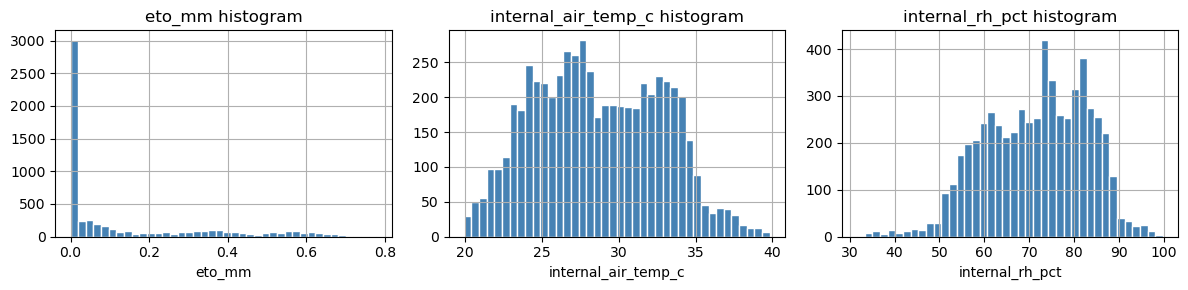

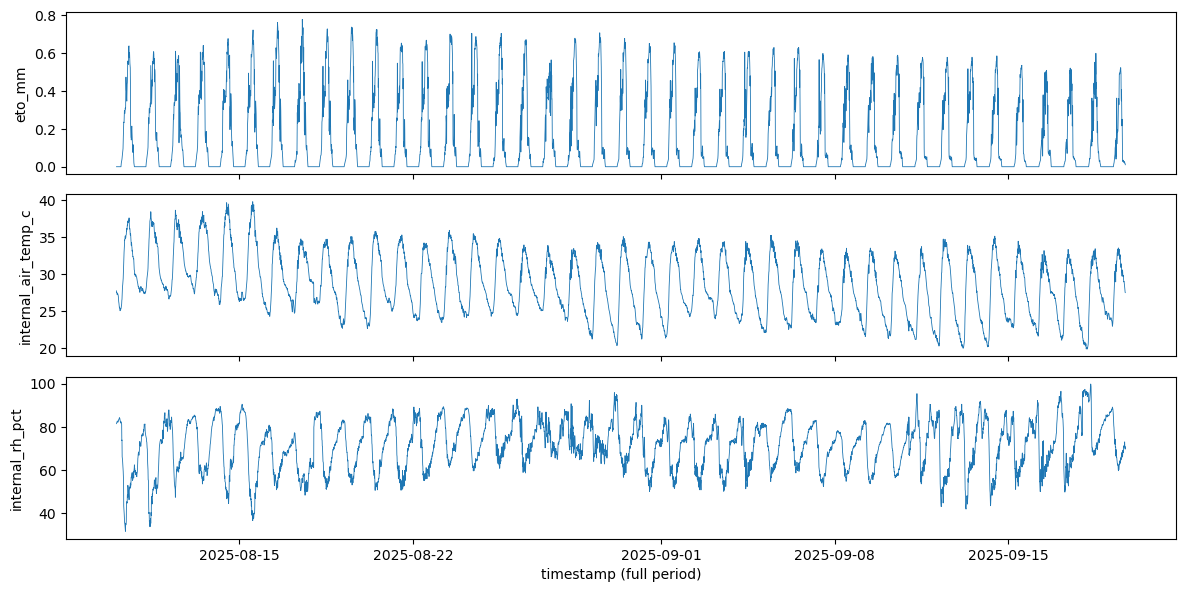

In [6]:
# Target distribution and full-period trajectories
display(full_df[target_cols].describe())

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
for ax, target in zip(axes, target_cols):
    full_df[target].hist(ax=ax, bins=40, color='steelblue', edgecolor='white')
    ax.set_title(f'{target} histogram')
    ax.set_xlabel(target)
plt.tight_layout()
plt.show()

# Full time-series for all rows
fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
for ax, target in zip(axes, target_cols):
    ax.plot(full_df['timestamp'], full_df[target], linewidth=0.6)
    ax.set_ylabel(target)
axes[-1].set_xlabel('timestamp (full period)')
plt.tight_layout()
plt.show()


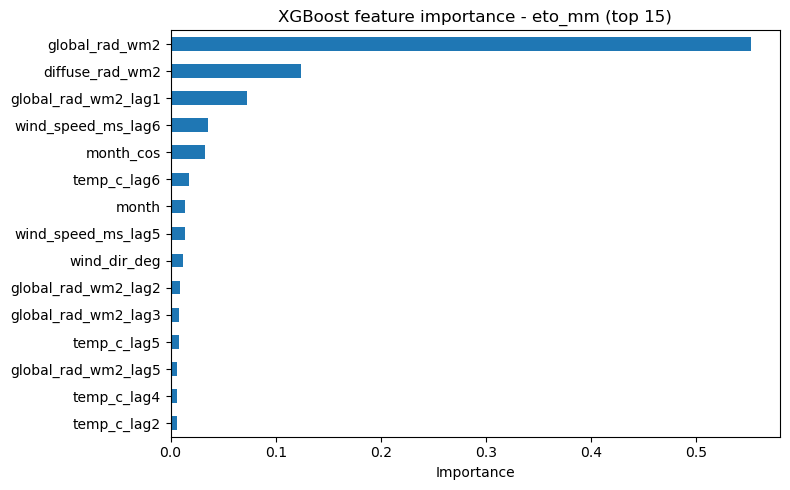

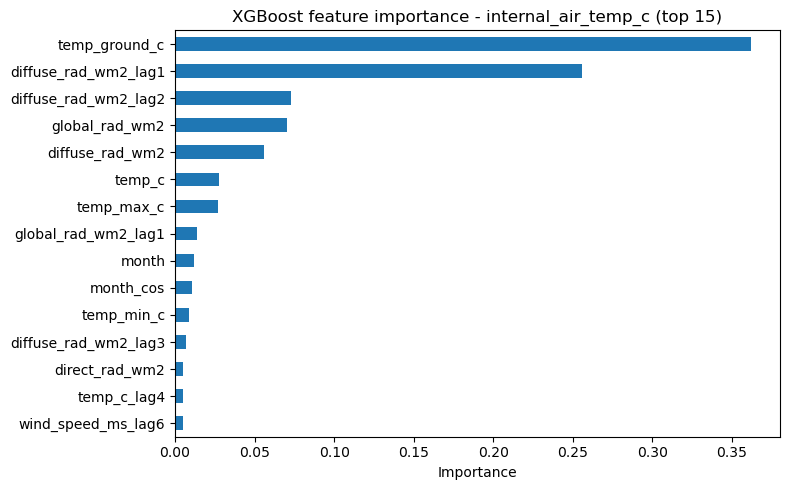

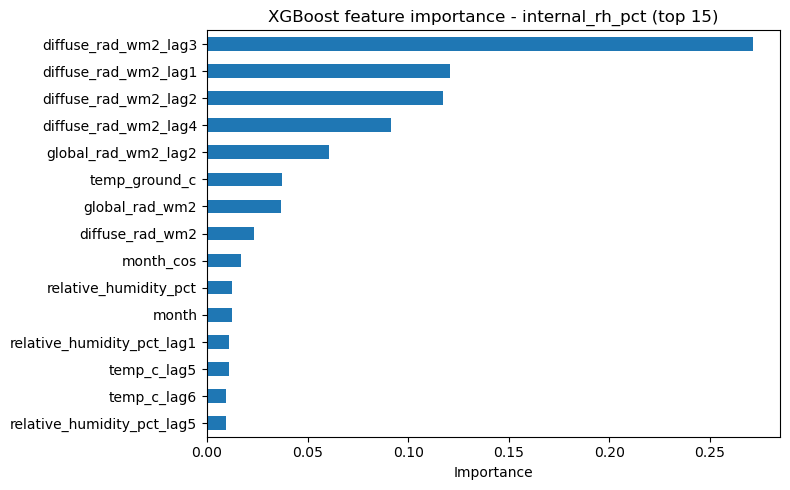

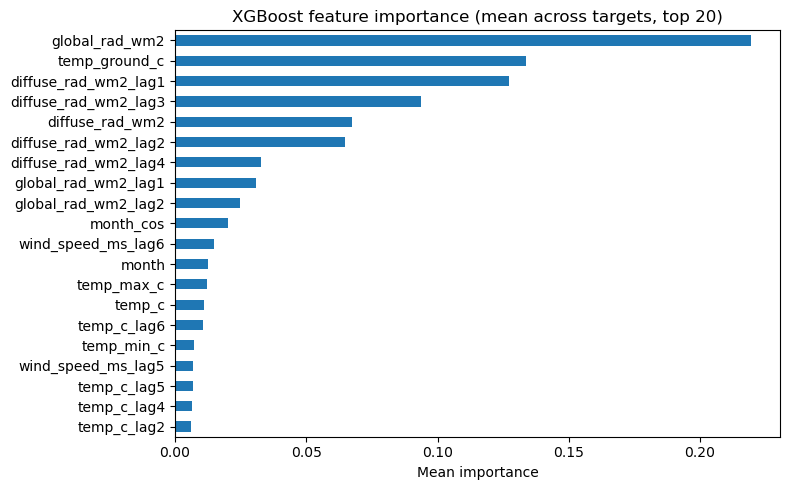

In [7]:
# XGBoost per-target models (multi-output via one model per target)
from xgboost import XGBRegressor

xgb_params = dict(
    n_estimators=800,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.9,
    colsample_bytree=0.9,
    objective='reg:squarederror',
    random_state=42,
    tree_method='hist',
)

xgb_models = []
xgb_preds = []
for i, target in enumerate(target_cols):
    model = XGBRegressor(**xgb_params)
    model.fit(X_train, y_train.iloc[:, i])
    xgb_models.append(model)
    xgb_preds.append(model.predict(X_test))

xgb_pred_mat = np.vstack(xgb_preds).T
xgb_pred_df = pd.DataFrame(xgb_pred_mat, columns=target_cols)
xgb_pred_df['eto_mm'] = xgb_pred_df['eto_mm'].clip(lower=0)
xgb_pred_df['internal_rh_pct'] = xgb_pred_df['internal_rh_pct'].clip(lower=0, upper=100)
xgb_pred = xgb_pred_df.values

# Feature importances per target and aggregated mean
imp_per_target = []
for i, target in enumerate(target_cols):
    s = pd.Series(xgb_models[i].feature_importances_, index=feature_cols, name=target)
    imp_per_target.append(s)
    top = s.sort_values(ascending=False).head(15)
    plt.figure(figsize=(8,5))
    top.iloc[::-1].plot(kind='barh')
    plt.title(f'XGBoost feature importance - {target} (top 15)')
    plt.xlabel('Importance')
    plt.tight_layout()
    plt.show()

imp_df = pd.concat(imp_per_target, axis=1)
imp_df['mean_importance'] = imp_df.mean(axis=1)
top_mean = imp_df['mean_importance'].sort_values(ascending=False).head(20)
plt.figure(figsize=(8,5))
top_mean.iloc[::-1].plot(kind='barh')
plt.title('XGBoost feature importance (mean across targets, top 20)')
plt.xlabel('Mean importance')
plt.tight_layout()
plt.show()


In [8]:
# Predict on full weather/radiation range up to 2025-08-10 (no internal targets available)
cutoff = pd.Timestamp('2025-08-10')  # exclude Aug 10 itself
met_pred = pd.merge(
    weather.drop(columns=['station', 'wind_10min_peak_end_hhmm']),
    rad.drop(columns=['station']),
    on='timestamp',
    how='inner'
)
met_pred = met_pred.sort_values('timestamp')
met_pred = met_pred[met_pred['timestamp'] < cutoff]

# Remove all-NaN columns (e.g., temp_low_c) to avoid losing all rows on dropna
na_full_cols = [c for c in met_pred.columns if met_pred[c].isna().all()]
if na_full_cols:
    print('Dropping all-NaN columns:', na_full_cols)
    met_pred = met_pred.drop(columns=na_full_cols)

# Light fill for radiation/temperature/wind/RH gaps before lags to retain days
fill_cols = ['global_rad_wm2', 'diffuse_rad_wm2', 'temp_c', 'wind_speed_ms', 'relative_humidity_pct']
met_pred[fill_cols] = met_pred[fill_cols].interpolate(limit=6).ffill().bfill()

# Season signals (hour features removed)
met_pred['month'] = met_pred['timestamp'].dt.month
met_pred['month_sin'] = np.sin(2 * np.pi * met_pred['month'] / 12)
met_pred['month_cos'] = np.cos(2 * np.pi * met_pred['month'] / 12)

# External lags (t-1..t-6)
lag_cols = ['relative_humidity_pct', 'temp_c', 'global_rad_wm2', 'diffuse_rad_wm2', 'wind_speed_ms']
for col in lag_cols:
    for k in range(1, 7):
        met_pred[f'{col}_lag{k}'] = met_pred[col].shift(k)

# Drop rows that lack lag history
met_pred = met_pred.dropna()

# Align features to training feature_cols
for col in feature_cols:
    if col not in met_pred.columns:
        met_pred[col] = 0.0
pred_X = met_pred[feature_cols]

# Predict per target with trained XGB models
preds = []
for i, model in enumerate(xgb_models):
    preds.append(model.predict(pred_X))
pred_mat = np.vstack(preds).T
pred_df = pd.DataFrame({
    'timestamp': met_pred['timestamp'].values,
    'pred_eto_mm': np.clip(pred_mat[:, 0], 0, None),
    'pred_internal_air_temp_c': pred_mat[:, 1],
    'pred_internal_rh_pct': np.clip(pred_mat[:, 2], 0, 100),
})
pred_df['timestamp_dayfirst'] = pred_df['timestamp'].dt.strftime('%d/%m/%Y %H:%M:%S')

print(f"Prediction rows: {len(pred_df):,}")
pred_df.head()

pred_out_path = 'xgb_predictions_until_aug10.csv'
pred_df.to_csv(pred_out_path, index=False)
print(f"Saved predictions to {pred_out_path}")


Dropping all-NaN columns: ['temp_low_c']
Prediction rows: 10,495
Saved predictions to xgb_predictions_until_aug10.csv


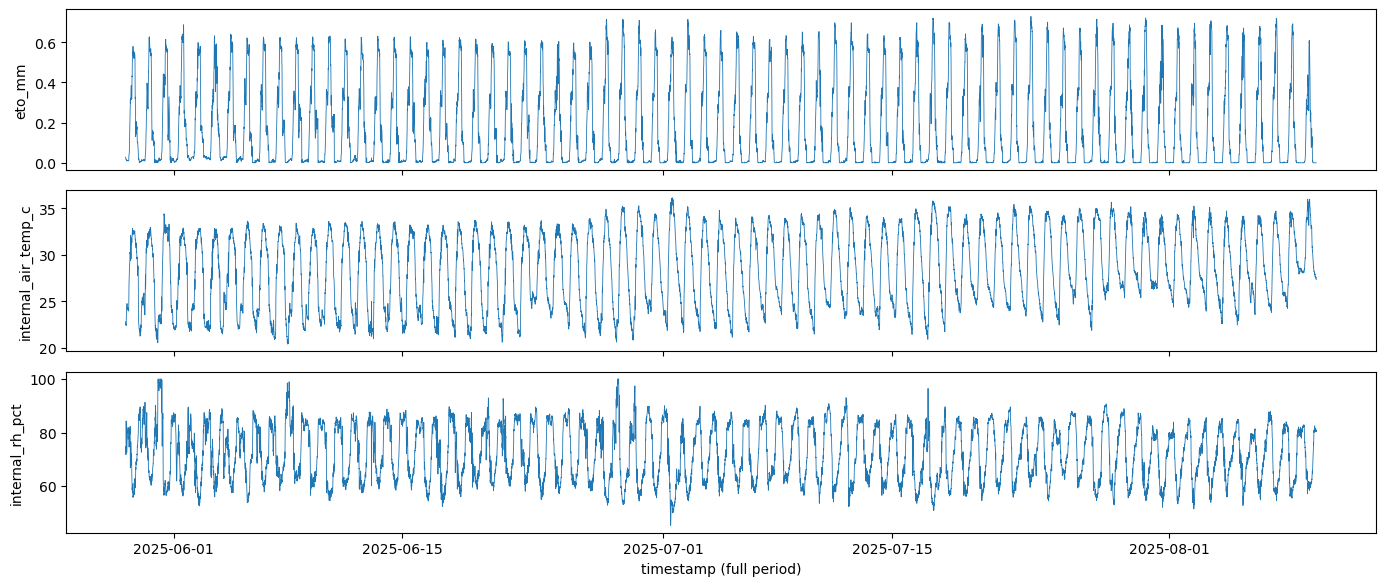

In [9]:
# Plot predictions over full period (saved CSV)
pred_path = 'xgb_predictions_until_aug10.csv'
pred_df = pd.read_csv(pred_path, parse_dates=['timestamp'])
pred_df = pred_df.sort_values('timestamp')

fig, axes = plt.subplots(3, 1, figsize=(14, 6), sharex=True)
axes[0].plot(pred_df['timestamp'], pred_df['pred_eto_mm'], linewidth=0.6)
axes[0].set_ylabel('eto_mm')
axes[1].plot(pred_df['timestamp'], pred_df['pred_internal_air_temp_c'], linewidth=0.6)
axes[1].set_ylabel('internal_air_temp_c')
axes[2].plot(pred_df['timestamp'], pred_df['pred_internal_rh_pct'], linewidth=0.6)
axes[2].set_ylabel('internal_rh_pct')
axes[2].set_xlabel('timestamp (full period)')
plt.tight_layout()
plt.show()


In [10]:
# Evaluation (uses xgb_pred from XGBoost cell)
rows = []
for idx, target in enumerate(target_cols):
    mae = mean_absolute_error(y_test.iloc[:, idx], xgb_pred[:, idx])
    r2 = r2_score(y_test.iloc[:, idx], xgb_pred[:, idx])
    rows.append({'target': target, 'MAE': mae, 'R2_pct': r2 * 100})
pd.DataFrame(rows)


,target,MAE,R2_pct
0,eto_mm,0.021095,94.559175
1,internal_air_temp_c,0.383234,98.024475
2,internal_rh_pct,2.377329,90.083644


In [12]:
pred_cols = [f'pred_{t}' for t in target_cols]
test_timestamps = full_df.loc[y_test.index, 'timestamp'].reset_index(drop=True)
preview = pd.concat(
    [test_timestamps.rename('timestamp'), y_test.reset_index(drop=True),
     pd.DataFrame(xgb_pred, columns=pred_cols)],
    axis=1
)
preview.head(10)


,timestamp,eto_mm,internal_air_temp_c,internal_rh_pct,pred_eto_mm,pred_internal_air_temp_c,pred_internal_rh_pct
0,2025-08-12 06:10:00,0.035301,27.9800,82.199238,0.035589,28.122833,80.841316
1,2025-08-29 10:20:00,0.365926,33.5900,71.355103,0.351742,33.944866,68.345871
2,2025-08-12 04:20:00,0.000011,27.0375,82.449593,0.001380,27.152538,83.997643
3,2025-09-18 04:20:00,0.000002,20.1200,95.388658,0.000000,20.068039,89.452400
4,2025-08-11 20:50:00,0.000020,29.0120,72.176337,0.000000,28.987625,72.989647
5,2025-08-21 14:40:00,0.140871,34.1120,52.574711,0.559047,34.285210,56.706196
6,2025-08-16 09:30:00,0.399872,34.6000,56.138948,0.370869,34.936749,55.679268
7,2025-09-06 17:10:00,0.032756,29.4200,68.800435,0.044564,28.943232,70.207207
8,2025-09-12 23:00:00,0.000014,23.2700,76.448976,0.000000,23.255545,78.787056
9,2025-08-27 02:20:00,0.000009,25.5900,85.126233,0.000660,25.545286,84.603416
